### Библиотеки

In [1]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from chronos import BaseChronosPipeline
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from torch.nn import Module
from tqdm.notebook import tqdm

import tsururu.dataset
from tsururu.model_training.trainer import DLTrainer, MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator, HoldOutValidator
from tsururu.models.boost import CatBoost, CatBoostRegressor
from tsururu.strategies import MIMOStrategy

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer

import statsforecast as stf
import statsforecast.models as stfm
from statsforecast import StatsForecast

import utilsforecast
import utilsforecast.losses
from utilsforecast.losses import mae, rmse, smape, mase, mape
from utilsforecast.evaluation import evaluate

import ta

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import EfficientFCParameters

import holidays

import optuna
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from catboost import CatBoostRegressor
from mlforecast import MLForecast
import pandas as pd
from tqdm import tqdm
import utilsforecast.losses
import catboost

from sklearn.ensemble import RandomForestRegressor

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, MASE
from neuralforecast.models import SOFTS
from neuralforecast.models import TimesNet
from neuralforecast.models import StemGNN

import sqlite3

warnings.filterwarnings("ignore")

/Users/mreshetnev/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Данные

#### Загружаем исходные данные

In [2]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    df = pd.read_sql('SELECT * FROM clean_prices', conn,
                     parse_dates={"TRADEDATE": {"format": "%Y-%m-%d"}})

In [5]:
df

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0


#### Обогащение данных

##### Лаговые переменные

In [6]:
lag_features = []

for lag_num in range(1, 8):
    df[f'lag{lag_num}_CLOSE'] = df.groupby('SECID')['CLOSE'].shift(lag_num)
    lag_features.append(f'lag{lag_num}_CLOSE')

display(df)

print(f'Добавлены признаки: {lag_features}')

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME,lag1_CLOSE,lag2_CLOSE,lag3_CLOSE,lag4_CLOSE,lag5_CLOSE,lag6_CLOSE,lag7_CLOSE
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0,13.890,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0,14.105,13.890,NaN,NaN,NaN,NaN,NaN
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0,13.451,14.105,13.890,NaN,NaN,NaN,NaN
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0,13.493,13.451,14.105,13.89,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0,4040.500,4054.000,4022.000,3989.50,4021.0,4114.5,4153.5
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0,3990.500,4040.500,4054.000,4022.00,3989.5,4021.0,4114.5
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0,4024.000,3990.500,4040.500,4054.00,4022.0,3989.5,4021.0
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0,4009.500,4024.000,3990.500,4040.50,4054.0,4022.0,3989.5


Добавлены признаки: ['lag1_CLOSE', 'lag2_CLOSE', 'lag3_CLOSE', 'lag4_CLOSE', 'lag5_CLOSE', 'lag6_CLOSE', 'lag7_CLOSE']


##### Признаки для дат

In [7]:
date_features = []

# Праздники
ru_holidays = holidays.country_holidays(
    'RU',
    years=range(2022, 2026)
)


df['weekend_flg'] = (df['TRADEDATE'].apply(lambda x: x.weekday()) >= 5).astype(int)
date_features.append('weekend_flg')

df['is_month_end'] = df['TRADEDATE'].apply(lambda x: x.is_month_end).astype(int)
date_features.append('is_month_end')

df['is_month_start'] = df['TRADEDATE'].apply(lambda x: x.is_month_start).astype(int)
date_features.append('is_month_start')

df['is_quarter_end'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_end).astype(int)
date_features.append('is_quarter_end')
df['is_quarter_start'] = df['TRADEDATE'].apply(lambda x: x.is_quarter_start).astype(int)
date_features.append('is_quarter_start')


df['is_holiday_in_russia'] = df['TRADEDATE'].apply(lambda x: x.date() in ru_holidays).astype(int)
date_features.append('is_holiday_in_russia')

df['pre_holiday_in_russa'] = df['TRADEDATE'].shift(-1).isin(ru_holidays).astype(int)
date_features.append('pre_holiday_in_russa')

df['after_holiday_in_russa'] = df['TRADEDATE'].shift(1).isin(ru_holidays).astype(int)
date_features.append('after_holiday_in_russa')


df['weekday'] = df['TRADEDATE'].apply(lambda x: x.weekday())
date_features.append('weekday')

df['month'] = df['TRADEDATE'].apply(lambda x: x.month)
date_features.append('month')

df['quart'] = df['TRADEDATE'].apply(lambda x: x.quarter)
date_features.append('quart')

display(df)

print(f'Добавлены признаки: {date_features}')

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME,lag1_CLOSE,lag2_CLOSE,...,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_holiday_in_russia,pre_holiday_in_russa,after_holiday_in_russa,weekday,month,quart
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0,NaN,NaN,...,0,1,0,1,0,0,0,4,4,2
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0,13.890,NaN,...,0,0,0,0,0,0,0,0,4,2
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0,14.105,13.890,...,0,0,0,0,0,0,0,1,4,2
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0,13.451,14.105,...,0,0,0,0,0,0,0,2,4,2
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0,13.493,13.451,...,0,0,0,0,0,0,0,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0,4040.500,4054.000,...,0,0,0,0,0,0,0,2,5,2
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0,3990.500,4040.500,...,0,0,0,0,0,0,0,3,5,2
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0,4024.000,3990.500,...,0,0,0,0,0,0,0,4,5,2
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0,4009.500,4024.000,...,0,0,0,0,0,0,0,0,5,2


Добавлены признаки: ['weekend_flg', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_holiday_in_russia', 'pre_holiday_in_russa', 'after_holiday_in_russa', 'weekday', 'month', 'quart']


##### Признаки из технического анализа

In [8]:
tech_analysis_features = []

# Сортируем данные по тикеру и дате
df = df.sort_values(by=['SECID', 'TRADEDATE'])

# Функция для расчета всех индикаторов в группе
def calculate_ta_indicators(group):
    # RSI
    rsi_indicator = ta.momentum.RSIIndicator(close=group['CLOSE'], window=14)
    group['rsi'] = rsi_indicator.rsi()
    
    # MACD
    macd_indicator = ta.trend.MACD(
        close=group['CLOSE'], 
        window_slow=26, 
        window_fast=12, 
        window_sign=9
    )
    group['macd'] = macd_indicator.macd()
    
    # Скользящие средние
    group['moving_average_short'] = group['CLOSE'].rolling(window=20).mean()
    group['moving_average_long'] = group['CLOSE'].rolling(window=50).mean()
    
    # Полосы Боллинджера
    bollinger = ta.volatility.BollingerBands(close=group['CLOSE'], window=20, window_dev=2)
    group['bollinger_upper'] = bollinger.bollinger_hband()
    group['bollinger_lower'] = bollinger.bollinger_lband()
    
    # Стохастический осциллятор
    stoch = ta.momentum.StochasticOscillator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14, 
        smooth_window=3
    )
    group['stoch_k'] = stoch.stoch()
    group['stoch_d'] = stoch.stoch_signal()
    
    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['atr'] = atr.average_true_range()
    
    # ADX
    adx = ta.trend.ADXIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=14
    )
    group['adx'] = adx.adx()
    
    # Williams %R
    williams_r = ta.momentum.WilliamsRIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        lbp=14
    )
    group['williams_r'] = williams_r.williams_r()
    
    # CCI
    cci = ta.trend.CCIIndicator(
        high=group['HIGH'], 
        low=group['LOW'], 
        close=group['CLOSE'], 
        window=20
    )
    group['cci'] = cci.cci()
    
    return group

# Применяем расчеты к каждой группе отдельно
df = df.groupby('SECID', group_keys=False).apply(calculate_ta_indicators)

tech_analysis_features = [
    'rsi', 'macd', 'moving_average_short', 'moving_average_long',
    'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d',
    'atr', 'adx', 'williams_r', 'cci'
]

display(df)
print(f'Добавлены признаки: {tech_analysis_features}')

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME,lag1_CLOSE,lag2_CLOSE,...,moving_average_short,moving_average_long,bollinger_upper,bollinger_lower,stoch_k,stoch_d,atr,adx,williams_r,cci
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0,13.890,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0,14.105,13.890,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0,13.451,14.105,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0,13.493,13.451,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0,4040.500,4054.000,...,4100.225,4264.83,4390.782477,3809.667523,44.458438,44.550237,142.320502,27.381767,-55.541562,-59.682512
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0,3990.500,4040.500,...,4083.300,4254.02,4349.161317,3817.438683,55.851064,48.461376,143.869037,27.610998,-44.148936,-49.657297
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0,4024.000,3990.500,...,4069.525,4243.63,4320.275768,3818.774232,51.994681,50.768061,137.306963,27.823856,-48.005319,-41.886977
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0,4009.500,4024.000,...,4050.725,4232.37,4287.635843,3813.814157,26.809651,44.885132,137.356466,28.727334,-73.190349,-92.615381


Добавлены признаки: ['rsi', 'macd', 'moving_average_short', 'moving_average_long', 'bollinger_upper', 'bollinger_lower', 'stoch_k', 'stoch_d', 'atr', 'adx', 'williams_r', 'cci']


##### Чистка от пропусков

In [10]:
df = df.dropna()
df

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME,lag1_CLOSE,lag2_CLOSE,...,moving_average_short,moving_average_long,bollinger_upper,bollinger_lower,stoch_k,stoch_d,atr,adx,williams_r,cci
49,2022-06-16,AFKS,12.601,12.510,12.695,12.441,12.748,24067400.0,12.461,12.550,...,12.7172,12.76714,13.241743,12.192657,55.405405,44.024024,0.469477,14.103937,-44.594595,-27.967641
50,2022-06-17,AFKS,12.611,12.700,12.508,12.508,12.741,9084900.0,12.695,12.461,...,12.6751,12.73950,13.118633,12.231567,38.558559,42.762763,0.452586,14.087248,-61.441441,-35.663787
51,2022-06-20,AFKS,12.833,12.549,12.830,12.522,13.000,35341000.0,12.508,12.695,...,12.6786,12.71400,13.125847,12.231353,67.567568,53.843844,0.455401,14.721709,-32.432432,44.520739
52,2022-06-21,AFKS,12.904,12.990,12.972,12.760,12.990,23216000.0,12.830,12.508,...,12.7066,12.70442,13.153697,12.259503,80.360360,62.162162,0.439301,15.310852,-19.639640,83.163072
53,2022-06-22,AFKS,12.767,12.975,12.900,12.620,13.071,23391800.0,12.972,12.830,...,12.7216,12.69256,13.173489,12.269711,73.873874,73.933934,0.440136,15.312309,-26.126126,60.583060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0,4040.500,4054.000,...,4100.2250,4264.83000,4390.782477,3809.667523,44.458438,44.550237,142.320502,27.381767,-55.541562,-59.682512
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0,3990.500,4040.500,...,4083.3000,4254.02000,4349.161317,3817.438683,55.851064,48.461376,143.869037,27.610998,-44.148936,-49.657297
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0,4024.000,3990.500,...,4069.5250,4243.63000,4320.275768,3818.774232,51.994681,50.768061,137.306963,27.823856,-48.005319,-41.886977
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0,4009.500,4024.000,...,4050.7250,4232.37000,4287.635843,3813.814157,26.809651,44.885132,137.356466,28.727334,-73.190349,-92.615381


##### Преобразовываем для обучения

Timestamp('2025-05-28 00:00:00')

In [60]:
def prepare_mlf_data(X, id_col='SECID', date_col='TRADEDATE', target_col='CLOSE', exog_cols=[]):
    return X[[id_col, date_col, target_col] + exog_cols].rename(columns={
        id_col: 'unique_id',
        date_col: 'ds',
        target_col: 'y'
    })


exog_cols = [col for col in df.columns if col not in set(['SECID', 'TRADEDATE', 'CLOSE'])]

X = prepare_mlf_data(df, exog_cols=exog_cols)

true_dates_range = sorted(X['ds'].unique())
true_dates_range.append(true_dates_range[-1] + pd.Timedelta(days=1))

reindexed_dates_range = list(pd.date_range(start=X['ds'].min(), periods=X['ds'].nunique()))
reindexed_dates_range.append(reindexed_dates_range[-1] + pd.Timedelta(days=1))

hashmap_reindex2true_dates = {false_date: true_date for true_date, false_date in zip(sorted(true_dates_range), 
                                                                                     sorted(reindexed_dates_range))}

hashmap_true2reindex_dates = {true_date: false_date for true_date, false_date in zip(sorted(true_dates_range), 
                                                                                     sorted(reindexed_dates_range))}

Переиндексируем для совместимости с библиотекой

In [61]:
X_train = X.copy()

X_train['ds'] = X['ds'].map(hashmap_true2reindex_dates)
X_train

,unique_id,ds,y,WAPRICE,OPEN,LOW,HIGH,VOLUME,lag1_CLOSE,lag2_CLOSE,...,moving_average_short,moving_average_long,bollinger_upper,bollinger_lower,stoch_k,stoch_d,atr,adx,williams_r,cci
49,AFKS,2022-06-16,12.695,12.601,12.510,12.441,12.748,24067400.0,12.461,12.550,...,12.7172,12.76714,13.241743,12.192657,55.405405,44.024024,0.469477,14.103937,-44.594595,-27.967641
50,AFKS,2022-06-17,12.508,12.611,12.700,12.508,12.741,9084900.0,12.695,12.461,...,12.6751,12.73950,13.118633,12.231567,38.558559,42.762763,0.452586,14.087248,-61.441441,-35.663787
51,AFKS,2022-06-18,12.830,12.833,12.549,12.522,13.000,35341000.0,12.508,12.695,...,12.6786,12.71400,13.125847,12.231353,67.567568,53.843844,0.455401,14.721709,-32.432432,44.520739
52,AFKS,2022-06-19,12.972,12.904,12.990,12.760,12.990,23216000.0,12.830,12.508,...,12.7066,12.70442,13.153697,12.259503,80.360360,62.162162,0.439301,15.310852,-19.639640,83.163072
53,AFKS,2022-06-20,12.900,12.767,12.975,12.620,13.071,23391800.0,12.972,12.830,...,12.7216,12.69256,13.173489,12.269711,73.873874,73.933934,0.440136,15.312309,-26.126126,60.583060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,YDEX,2024-07-01,3990.500,4009.000,4042.000,3971.000,4050.000,308142.0,4040.500,4054.000,...,4100.2250,4264.83000,4390.782477,3809.667523,44.458438,44.550237,142.320502,27.381767,-55.541562,-59.682512
35196,YDEX,2024-07-02,4024.000,3997.500,3980.500,3925.000,4089.000,773529.0,3990.500,4040.500,...,4083.3000,4254.02000,4349.161317,3817.438683,55.851064,48.461376,143.869037,27.610998,-44.148936,-49.657297
35197,YDEX,2024-07-03,4009.500,4016.500,4029.500,3996.000,4048.000,335528.0,4024.000,3990.500,...,4069.5250,4243.63000,4320.275768,3818.774232,51.994681,50.768061,137.306963,27.823856,-48.005319,-41.886977
35198,YDEX,2024-07-04,3917.000,3934.000,4004.000,3886.000,4024.000,505249.0,4009.500,4024.000,...,4050.7250,4232.37000,4287.635843,3813.814157,26.809651,44.885132,137.356466,28.727334,-73.190349,-92.615381


### Модель TimesNet

#### Данные для модели

In [41]:
X_train_Timesnet = X_train.loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True).sort_values(by=['unique_id', 'ds'])
X_train_Timesnet

,unique_id,ds,y
0,AFKS,2022-06-16,12.695
1,AFKS,2022-06-17,12.508
2,AFKS,2022-06-18,12.830
3,AFKS,2022-06-19,12.972
4,AFKS,2022-06-20,12.900
...,...,...,...
33039,YDEX,2024-07-01,3990.500
33040,YDEX,2024-07-02,4024.000
33041,YDEX,2024-07-03,4009.500
33042,YDEX,2024-07-04,3917.000


#### Параметры

In [ ]:
HORIZON = 1

INPUT_SIZE = 44

HIDDEN_SIZE = 128
CONV_HIDDEN_SIZE = 128

SCALER_TYPE = 'standard'

LOSS = MASE(seasonality=1)

LR=1e-3

MAX_STEPS = 200
VAL_CHECK_STEPS = 50

EARLY_STOP_PATIENCE_STEPS = 2

ALIAS = 'TimesNet'

RANDOM_SEED = 42

#### Обучение

In [43]:
# ИНИЦИАЛИЗАЦИЯ МОДЕЛИ
fcst = NeuralForecast(
    models=[TimesNet(h=HORIZON,
                    input_size=INPUT_SIZE,
                    hidden_size = HIDDEN_SIZE,
                    conv_hidden_size = CONV_HIDDEN_SIZE,
                    loss=LOSS,
                    scaler_type=SCALER_TYPE,
                    learning_rate=LR,
                    max_steps=MAX_STEPS,
                    val_check_steps=VAL_CHECK_STEPS,
                    early_stop_patience_steps=EARLY_STOP_PATIENCE_STEPS,
                    alias=ALIAS,
                    random_seed=RANDOM_SEED
                )
            ],
    freq='D'
)

# ОБУЧЕНИЕ
fcst.fit(df=X_train_Timesnet, val_size=1)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MASE          | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 18.7 M | train
4 | enc_embedding  | DataEmbedding | 384    | train
5 | layer_norm     | LayerNorm     | 256    | train
6 | predict_linear | Linear        | 2.0 K  | train
7 | projection     | Linear        | 129    | train
---------------------------------------------------------
18.7 M    Trainable params
0         Non-trainable params
18.7 M    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

#### Сохранение модели (?)

#### Прогноз

,unique_id,ds,y
750,AFKS,2024-07-05,14.89200
1501,AFLT,2024-07-05,65.25000
2252,ALRS,2024-07-05,44.60000
3003,BSPB,2024-07-05,374.17000
3754,CBOM,2024-07-05,6.50100
4505,CHMF,2024-07-05,951.80000
5256,ENPG,2024-07-05,364.00000
6007,FEES,2024-07-05,0.06538
6758,FLOT,2024-07-05,74.48000
7509,GAZP,2024-07-05,127.41000


In [105]:
# ПРОГНОЗ
forecasts = fcst.predict(X_train_Timesnet[X_train_Timesnet['ds'] == X_train_Timesnet['ds'].max()])

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [129]:
forecasts_to_prod = forecasts.copy()

# Переводим в нормальные индексы
forecasts_to_prod.loc[:, 'ds'] = forecasts.loc[:, 'ds'].map(hashmap_reindex2true_dates)

X_train_reindexed = X_train_Timesnet.copy()
X_train_reindexed.loc[:, 'ds'] = X_train_Timesnet.loc[:, 'ds'].map(hashmap_reindex2true_dates)

# Переименовываем столбец предсказаний
forecasts_to_prod.rename(columns={ALIAS: 'prediction'},
                         inplace=True)

# Добавляем столбец с моделью прогноза
forecasts_to_prod.loc[:, 'model_name'] = ALIAS

# Время когда был сделан прогноз
now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")

forecasts_to_prod.loc[:, 'prediction_dttm'] = pd.to_datetime(current_time)

# Описание предсказаний
X_train_reindexed_last_date = X_train_reindexed.loc[X_train_reindexed['ds'] == X_train_reindexed['ds'].max()]

forecast_results = forecasts_to_prod.merge(X_train_reindexed_last_date.loc[:, ['y', 'unique_id']], how='inner', left_on='unique_id', right_on='unique_id')
forecast_results.rename(columns={'y': 'last_y'},
              inplace=True)

forecast_results['delta'] = forecast_results['prediction'] - forecast_results['last_y']
forecast_results['delta_perc'] = forecast_results['delta'] / forecast_results['last_y']

forecast_results['direction'] = np.where(
    forecast_results['prediction'] > forecast_results['last_y'], 'Рост',
    np.where(
        forecast_results['prediction'] < forecast_results['last_y'], 'Падение',
        'Без изменений'
    )
)

forecast_results

,unique_id,ds,prediction,model_name,prediction_dttm,last_y,delta,delta_perc,direction
0,AFKS,2025-05-28,15.322610,TimesNet,2025-05-28 03:11:40,14.89200,0.430610,0.028916,Рост
1,AFLT,2025-05-28,65.643387,TimesNet,2025-05-28 03:11:40,65.25000,0.393387,0.006029,Рост
2,ALRS,2025-05-28,44.998432,TimesNet,2025-05-28 03:11:40,44.60000,0.398432,0.008933,Рост
3,BSPB,2025-05-28,374.554443,TimesNet,2025-05-28 03:11:40,374.17000,0.384443,0.001027,Рост
4,CBOM,2025-05-28,6.991590,TimesNet,2025-05-28 03:11:40,6.50100,0.490590,0.075464,Рост
5,CHMF,2025-05-28,952.183228,TimesNet,2025-05-28 03:11:40,951.80000,0.383228,0.000403,Рост
6,ENPG,2025-05-28,364.384460,TimesNet,2025-05-28 03:11:40,364.00000,0.384460,0.001056,Рост
7,FEES,2025-05-28,0.670905,TimesNet,2025-05-28 03:11:40,0.06538,0.605525,9.261619,Рост
8,FLOT,2025-05-28,74.872040,TimesNet,2025-05-28 03:11:40,74.48000,0.392040,0.005264,Рост
9,GAZP,2025-05-28,127.798088,TimesNet,2025-05-28 03:11:40,127.41000,0.388088,0.003046,Рост


#### Визуализация прогноза

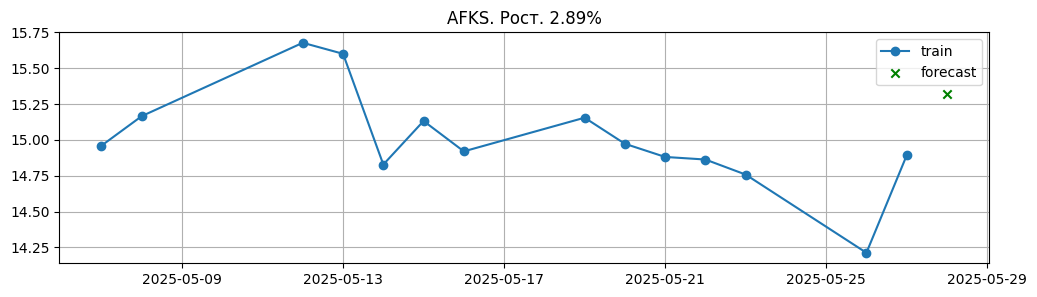

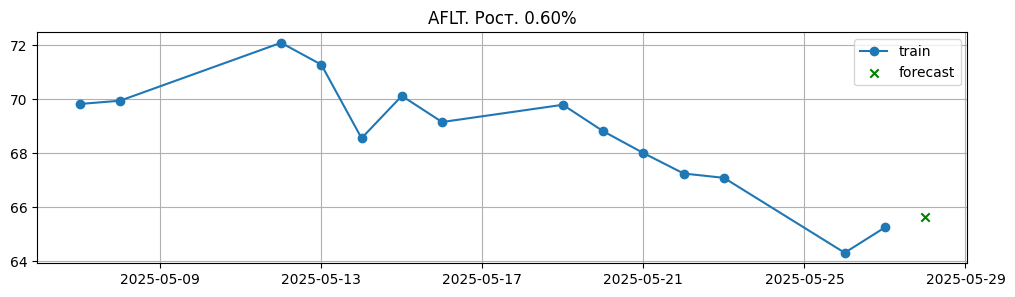

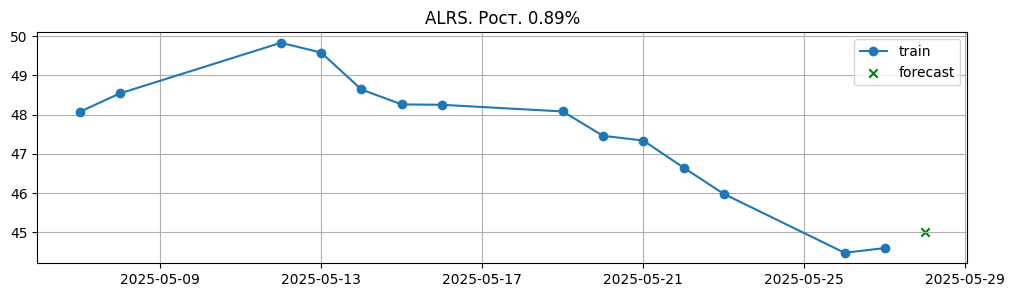

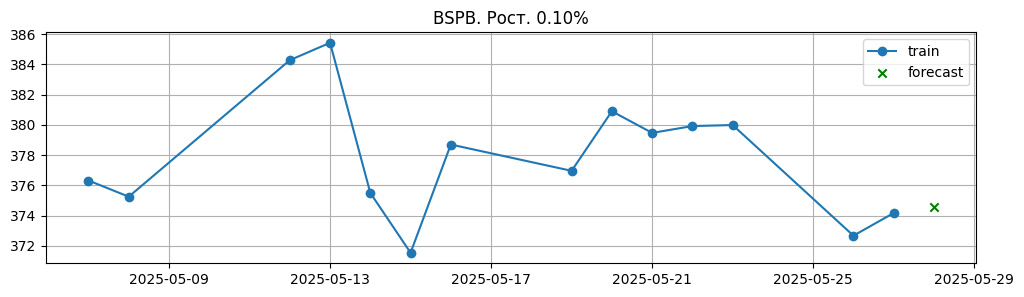

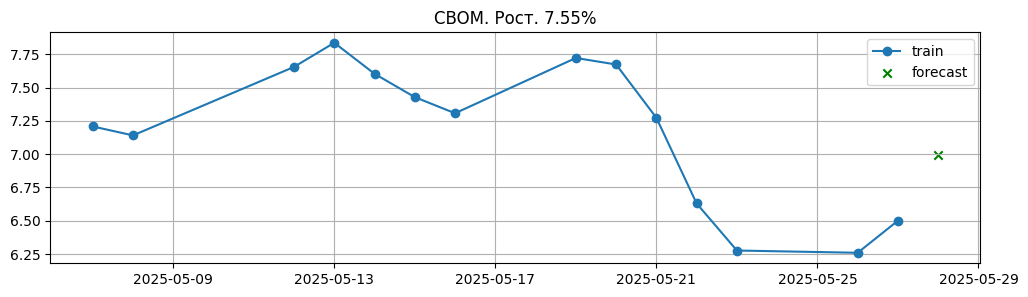

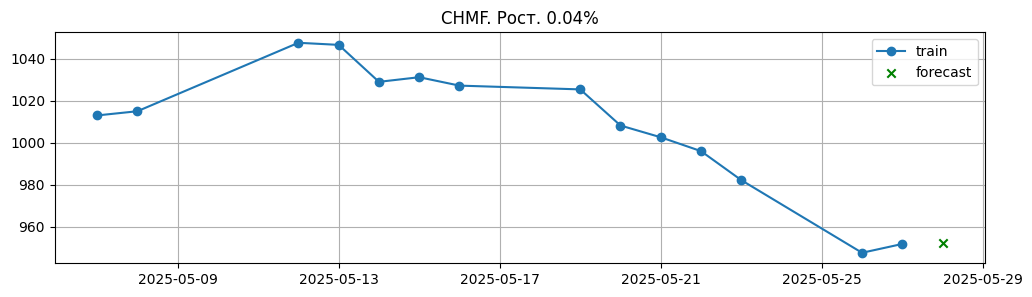

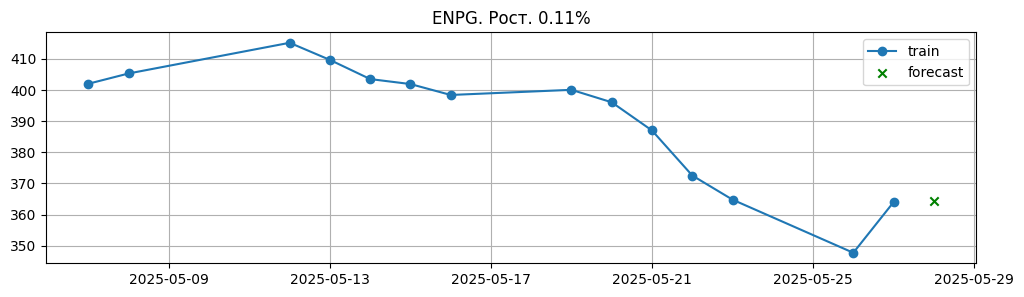

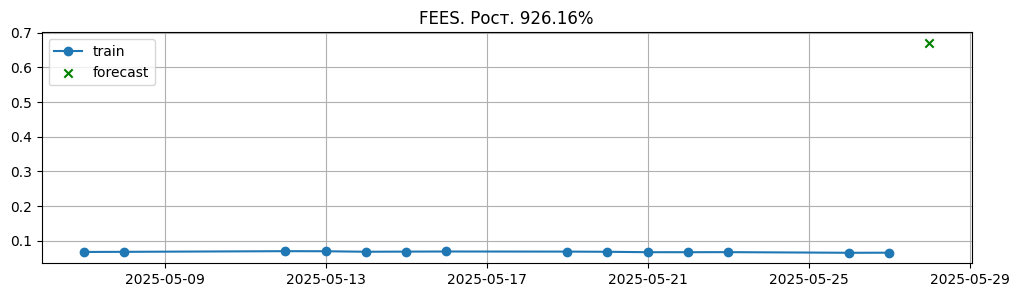

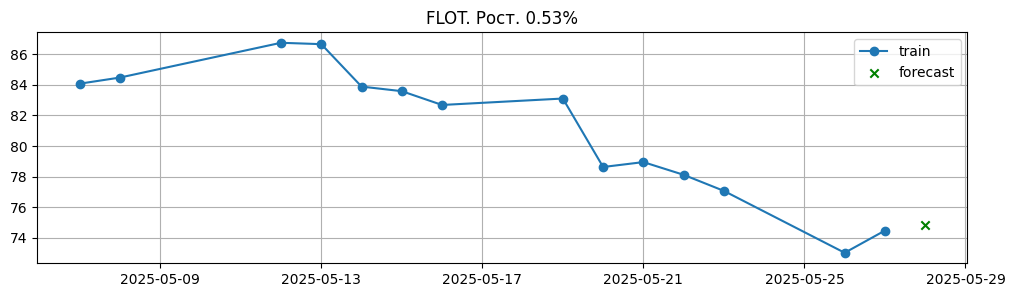

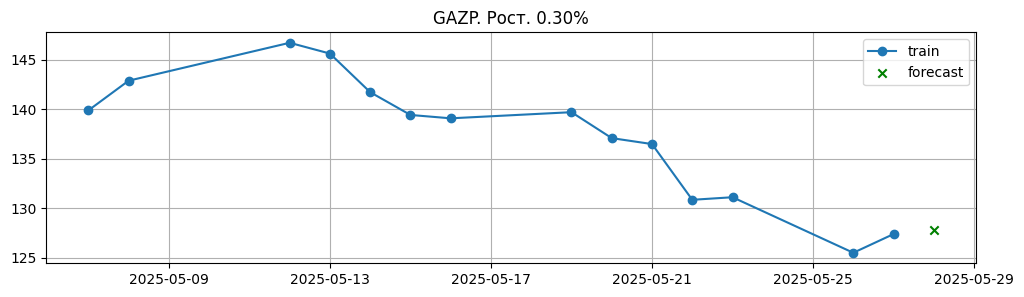

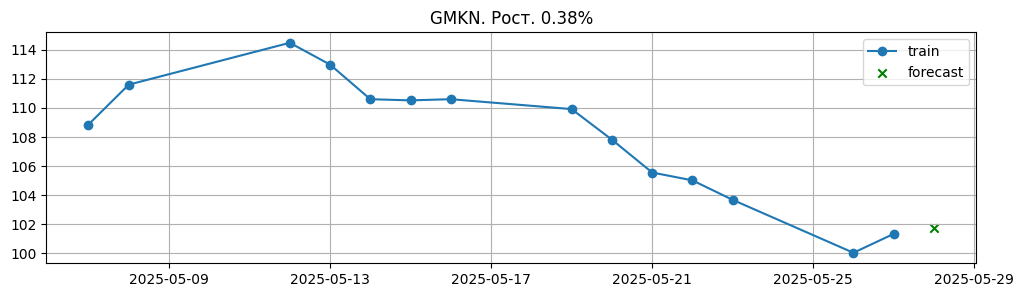

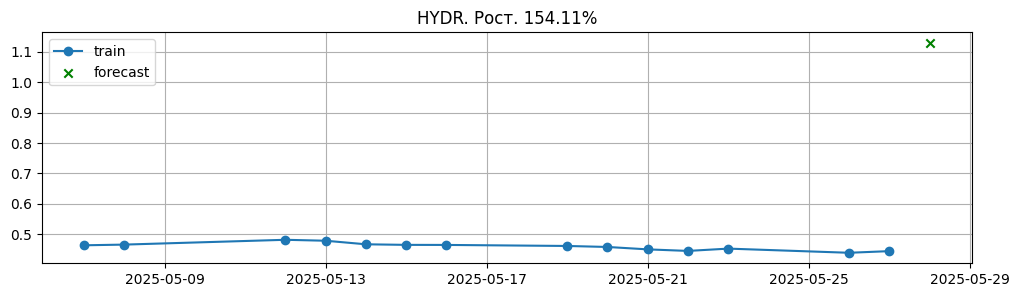

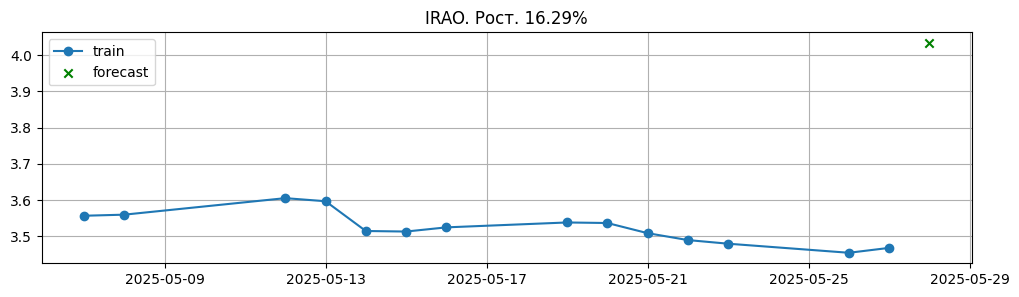

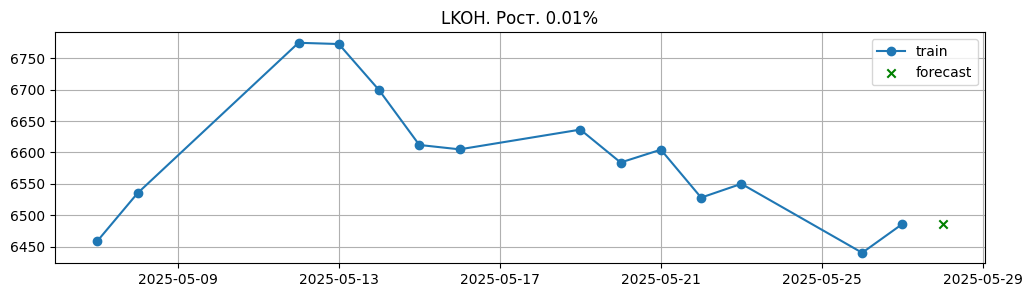

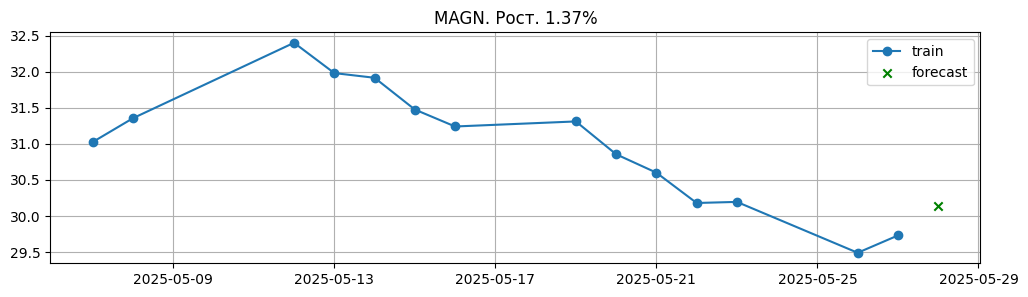

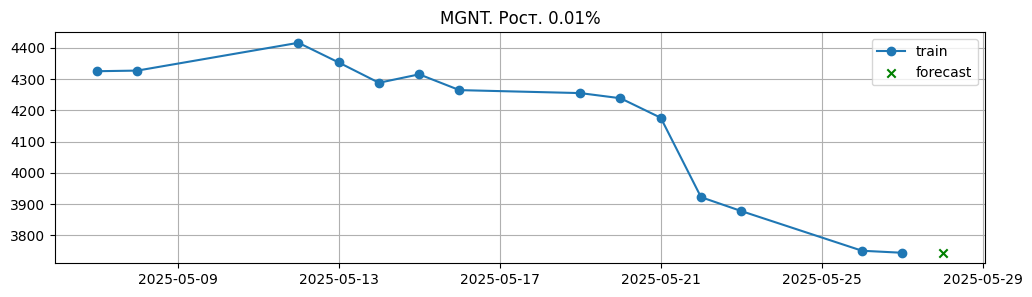

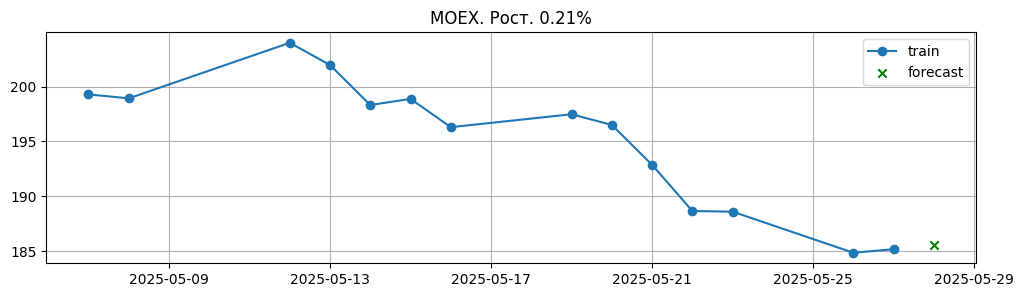

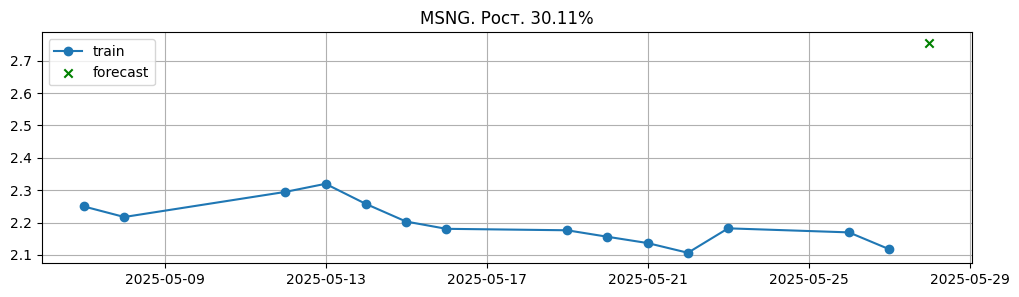

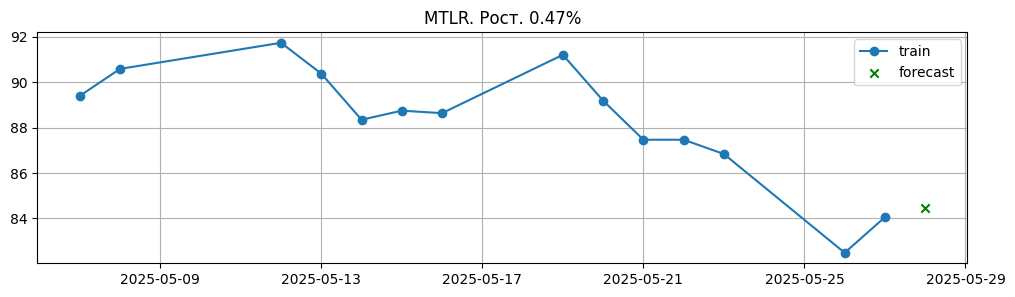

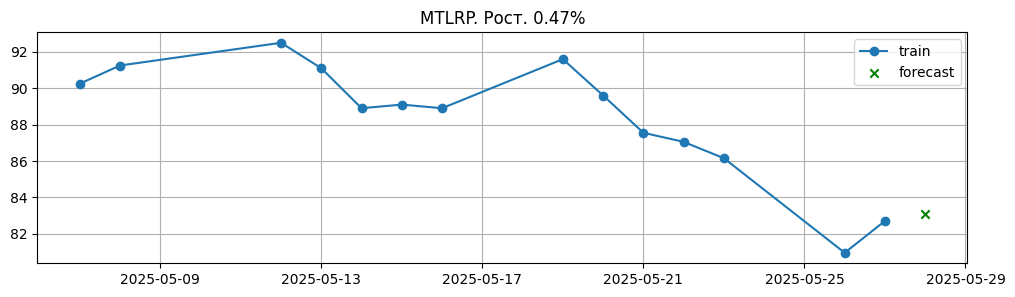

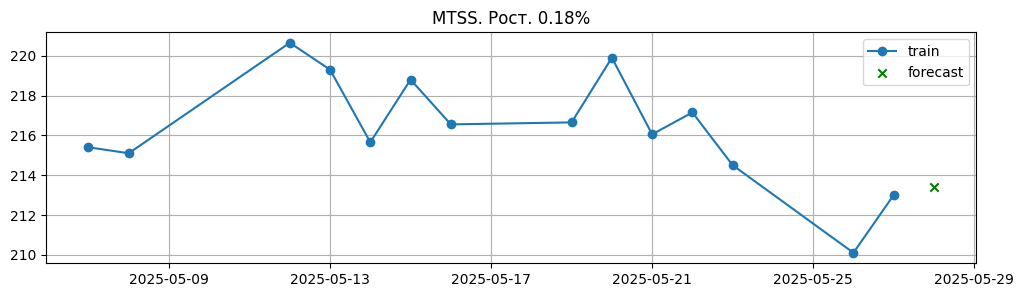

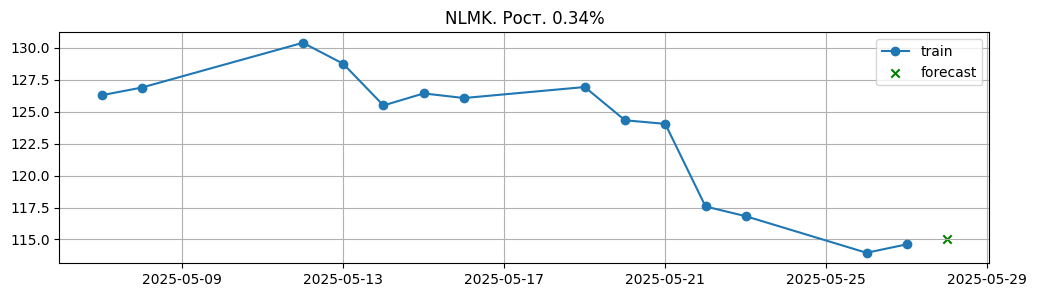

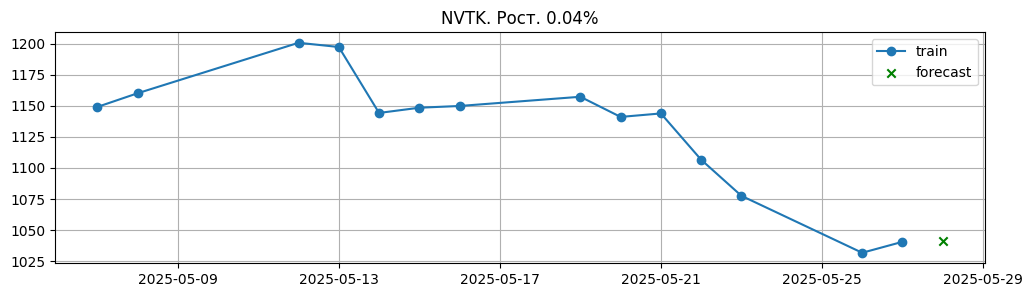

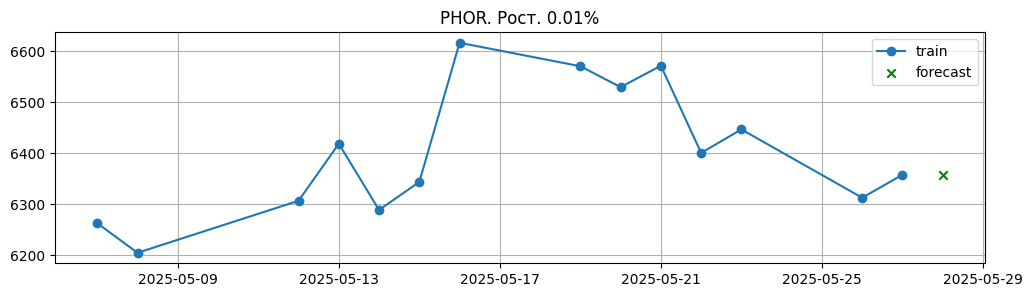

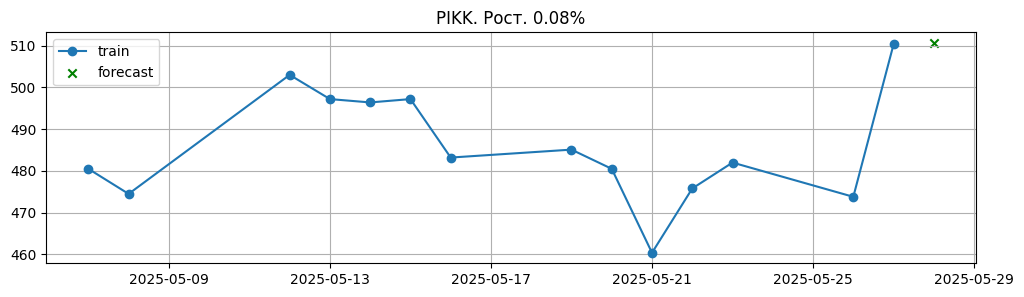

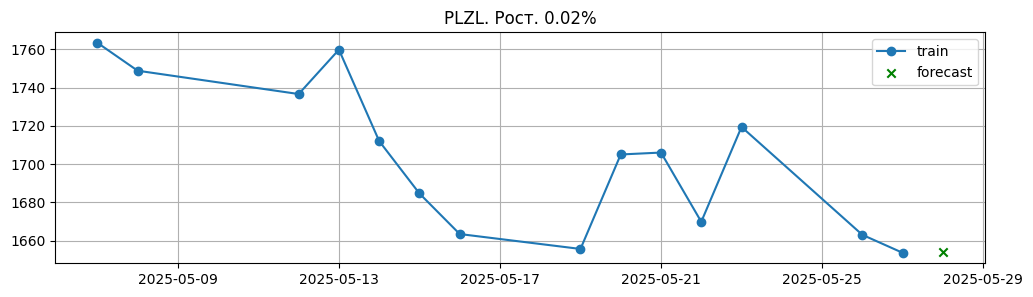

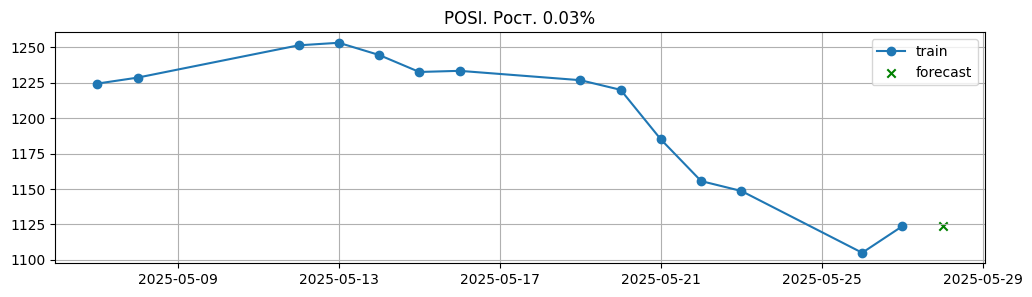

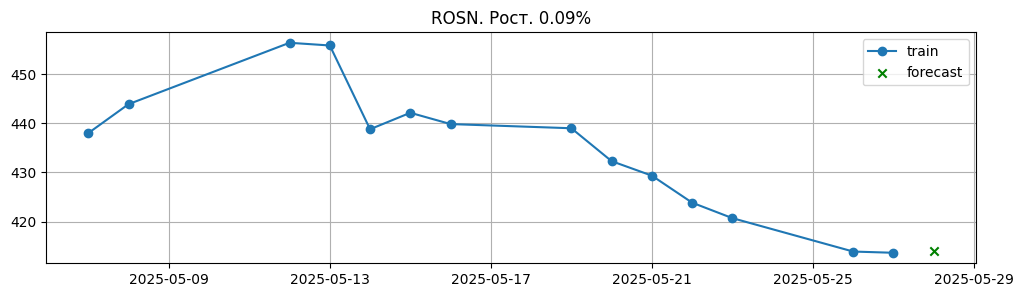

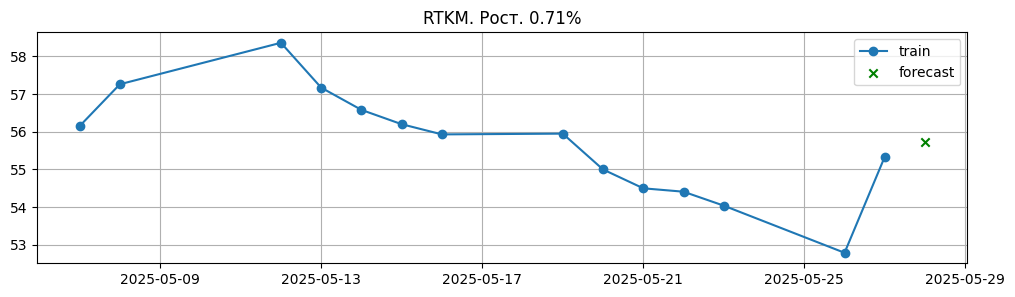

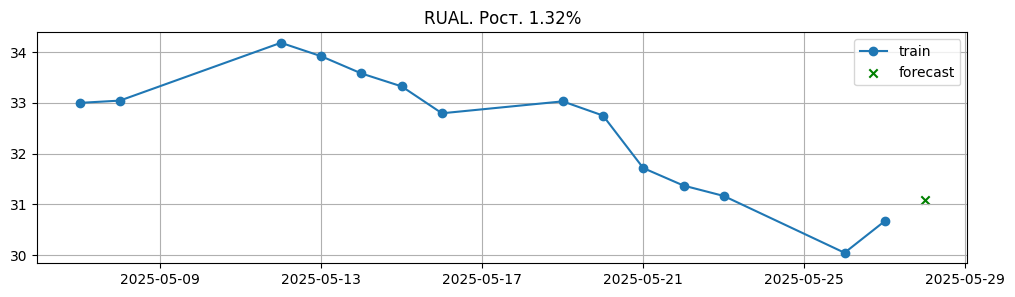

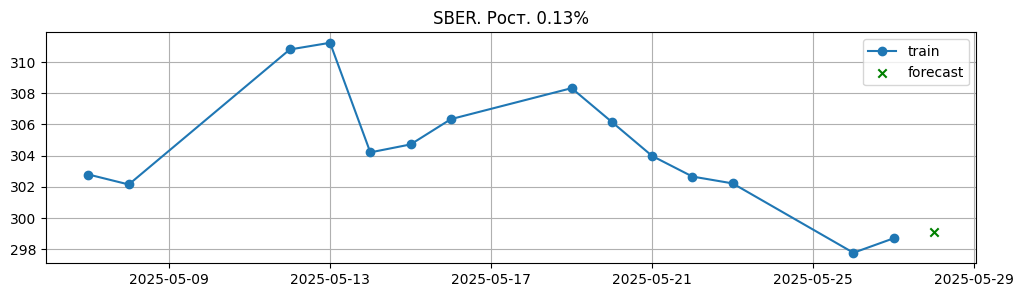

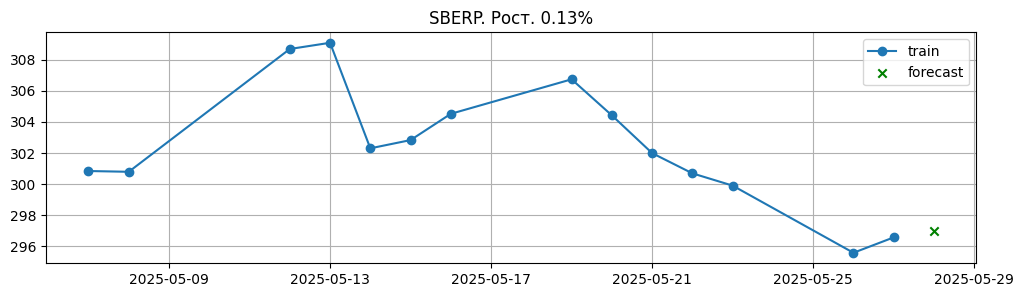

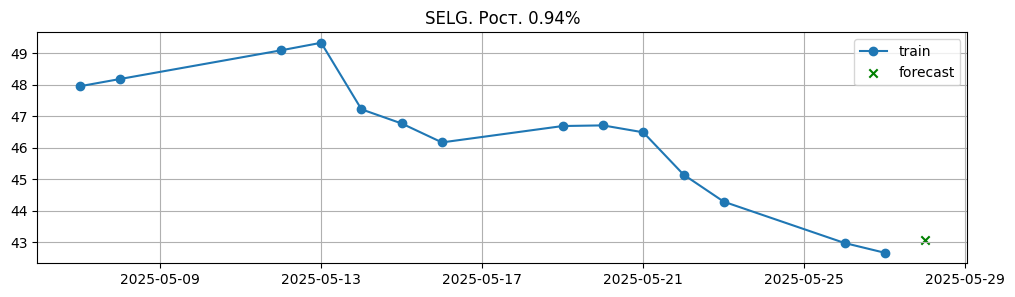

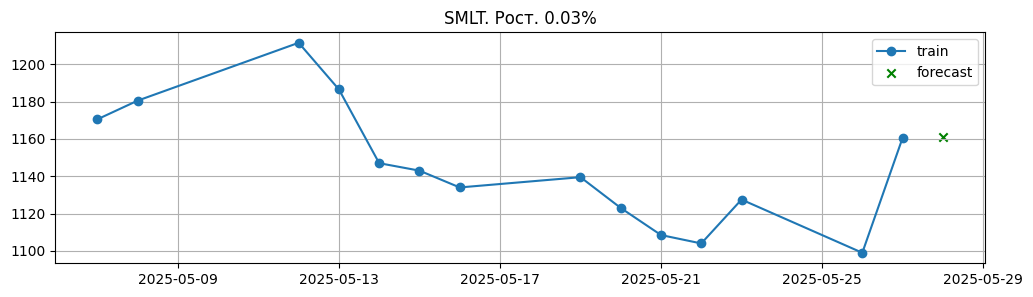

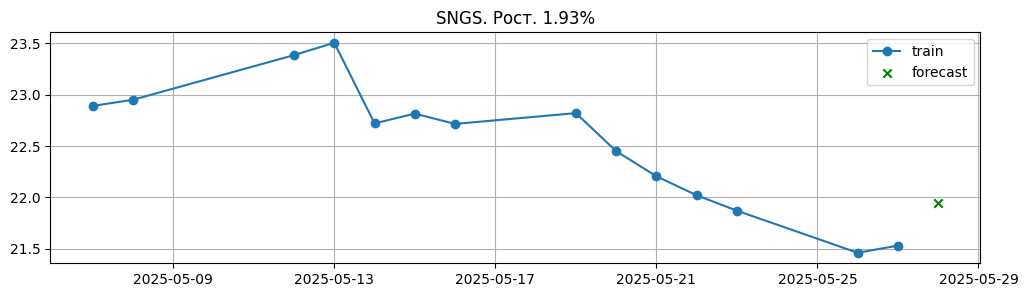

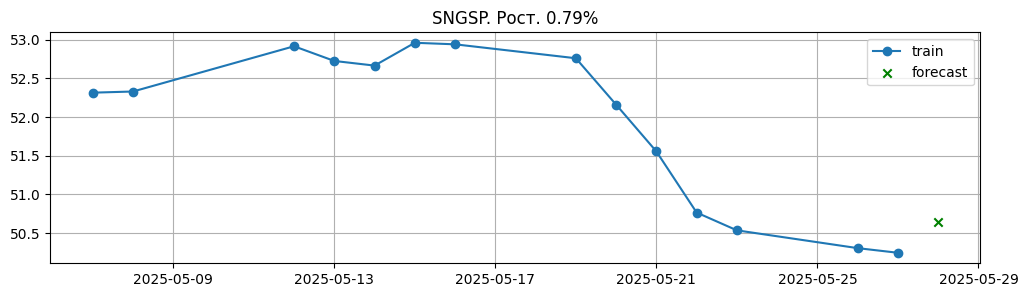

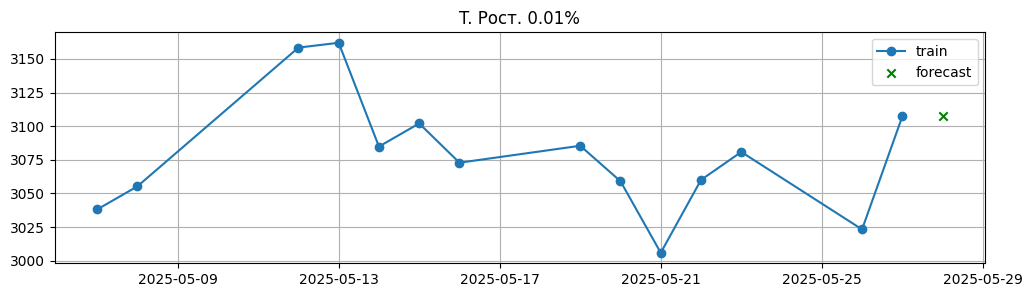

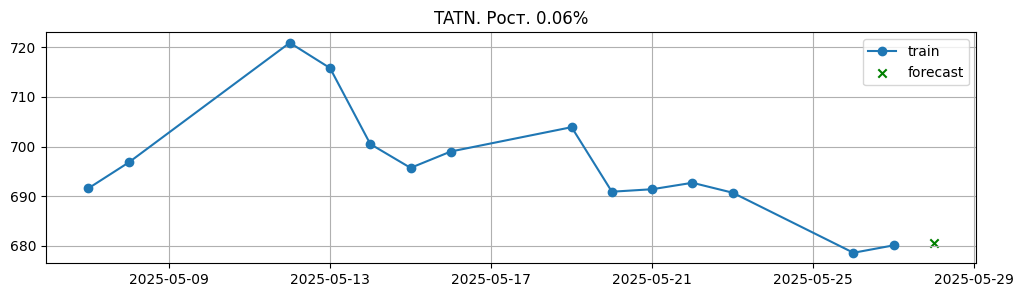

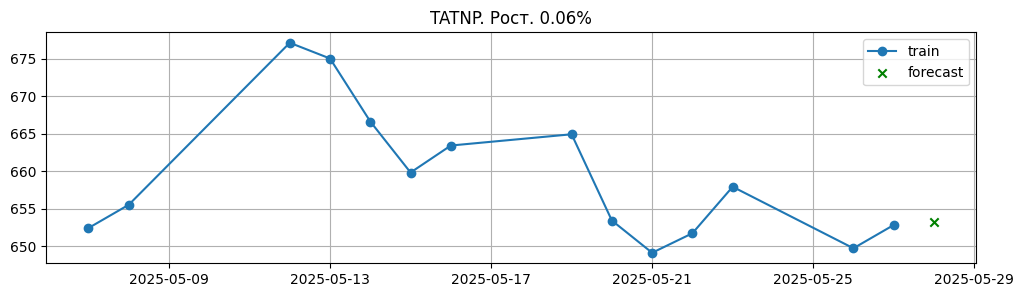

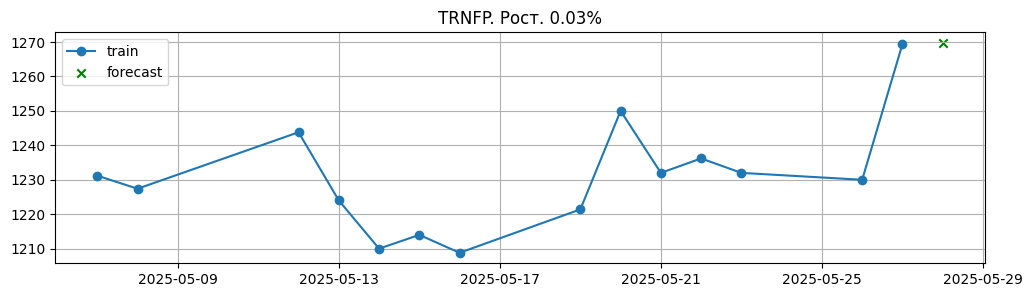

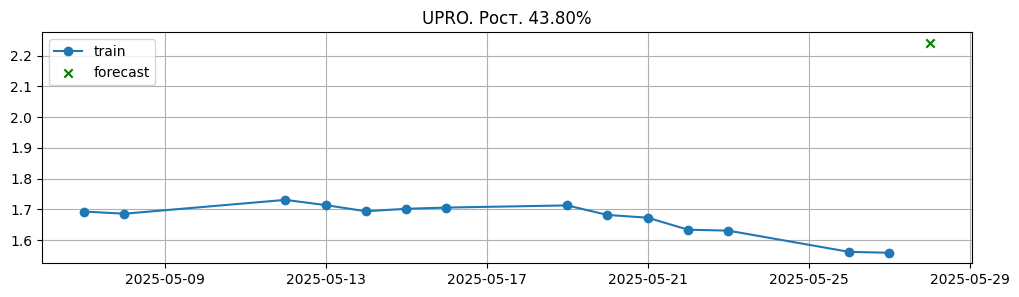

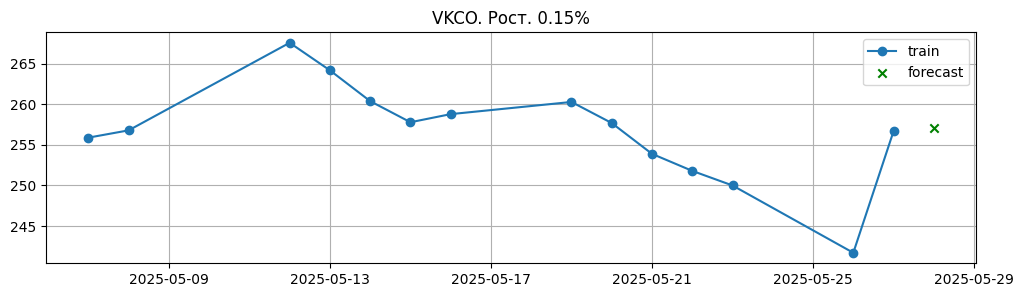

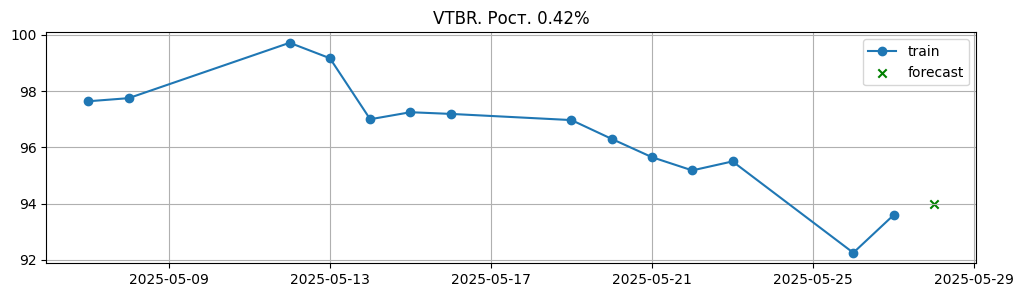

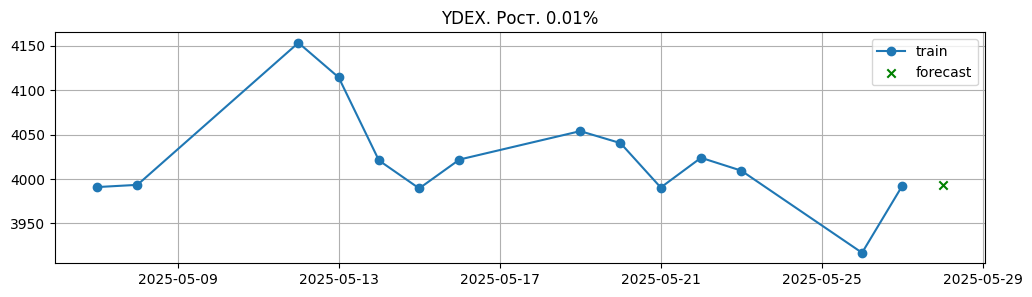

In [133]:
for ticker in forecast_results['unique_id'].unique():
    plt.figure(figsize=(12, 3))

    row_ticker = X_train_reindexed[(X_train_reindexed['unique_id'] == ticker) & (X_train_reindexed['ds'] >= X_train_reindexed['ds'].max() + pd.Timedelta(days=-20))]
    row_forecasts = forecast_results[forecast_results['unique_id'] == ticker]

    forecast_point = row_forecasts['prediction'].values[0]
    train_last_point = row_forecasts['last_y'].values[0]

    delta = row_forecasts['delta'].values[0]
    delta_perc = row_forecasts['delta_perc'].values[0]

    direction = row_forecasts['direction'].values[0]

    plt.title(f'{ticker}. {direction}. {delta_perc:.2%}')

    plt.plot(row_ticker['ds'], row_ticker['y'], label='train', marker='o')

    if direction == 'Рост':
        prediction_color = 'g'
    elif direction == 'Падение':
        prediction_color = 'r'
    elif direction == 'Без изменений':
        prediction_color = 'blue'

    plt.scatter(row_forecasts['ds'], row_forecasts['prediction'], marker='x', label='forecast', c=prediction_color)

    plt.grid()
    plt.legend()

### Сохранение прогноза

In [134]:
def update_predictions(df, db_path='moex_stock_price_prediction_service.db'):
    """
    Добавляет данные в таблицу predictions, обновляя существующие записи при совпадении ключей
    
    Параметры:
    df (pd.DataFrame): DataFrame с предсказаниями
    db_path (str): Путь к файлу базы данных
    """
    # Проверяем обязательные колонки
    required_columns = ['unique_id', 'ds', 'prediction', 'model_name', 
                       'prediction_dttm', 'last_y', 'delta', 'delta_perc', 'direction']
    
    if not all(col in df.columns for col in required_columns):
        missing = set(required_columns) - set(df.columns)
        raise ValueError(f"Отсутствуют обязательные колонки: {missing}")
    
    # Подключаемся к базе данных
    with sqlite3.connect(db_path) as conn:
        # Создаем таблицу если ее нет
        conn.execute('''
        CREATE TABLE IF NOT EXISTS predictions (
            unique_id TEXT,
            ds TEXT,
            prediction REAL,
            model_name TEXT,
            prediction_dttm TEXT,
            last_y REAL,
            delta REAL,
            delta_perc REAL,
            direction TEXT,
            PRIMARY KEY (unique_id, ds, model_name, prediction_dttm)
        )
        ''')
        
        # Используем временную таблицу для UPSERT (обновления/вставки)
        temp_table = 'temp_predictions'
        df.to_sql(temp_table, conn, if_exists='replace', index=False)
        
        # SQL-запрос для UPSERT
        upsert_query = f'''
        INSERT OR REPLACE INTO predictions
        SELECT * FROM {temp_table}
        '''
        
        # Выполняем UPSERT
        conn.execute(upsert_query)
        
        # Удаляем временную таблицу
        conn.execute(f'DROP TABLE {temp_table}')
        
        # Фиксируем изменения
        conn.commit()
    
    print(f"✅ Данные успешно добавлены/обновлены в таблице predictions ({len(df)} записей)")

In [135]:
update_predictions(forecast_results)

✅ Данные успешно добавлены/обновлены в таблице predictions (44 записей)
